# Data Mining Project
## Konstantinos Georgiou
Dataset: [COVID-19 World Vaccination Progress](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)

## Information About The Dataset

This dataset contains information about the vaccinations happening in each country daily. The data are being collected almost daily from this website using this code. As of writing this (2/27), the dataset has 4,380 rows with vaccination data for 112 unique countries and is in the CSV format.

It has 15 columns in total, including among others the country name, the daily vaccination, the vaccinated people per million that date, and the source of each record.

- Country- this is the country for which the vaccination information is provided;
- Country ISO Code - ISO code for the country;
- Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
- Total number of vaccinations - this is the absolute number of total immunizations in the country;
- Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
- Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
- Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
- Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
- Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
- Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
- Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
- Number of vaccinations per day - number of daily vaccination for that day and country;
- Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
- Vaccines used in the country - total number of vaccines used in the country (up to date);
- Source name - source of the information (national authority, international organization, local organization etc.);
- Source website - website of the source of information;


## Questions To Be Answered

- Can you identify countries that faced bottlenecks on their daily vaccination rates?
- Can you cluster together countries that faced similar bottlenecks? In what sense are they related?
- Can you enrich the data with more info (country location, GDP, etc) to achieve better results on the previous question?
- Can you track down the bottlenecks and find patterns in how they propagate from day to day from one cluster to another?
- Can you predict future bottlenecks on some clusters based on these patterns?

## Some details
- To setup this project on any machine, just run `make install`. More details in the [Readme](README.md).
- To download the latest version of the dataset (new rows are added every day), run `make download_dataset`
- The dataset is in the <a>datasets/covid-world-vaccinations-progress</a> directory
- In the [data mining directory](data_mining) are located three custom packages:
    - Configuration: for handling the yml configuration
    - ColorizedLogger: For formatted logging that saves output in log files
    - timeit: ContextManager&Decorator for timing functions and code blocks
- The project was compiled using my Template **Cookiecutter** project: <a>https://github.com/drkostas/starter</a>

## Code

### Load Libraries and configuration
Configuration path: `confs/covid.yml`

In [75]:
from data_mining import timeit, ColorizedLogger, Configuration
text_color = 'lightgrey'
# text_color = 'black'

In [163]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

In [5]:
# Load the configuration
conf_obj = Configuration(config_src='confs/covid.yml')
covid_conf = conf_obj.get_config('covid-progress')[0]
data_path = covid_conf['properties']['data_path']
log_path = covid_conf['properties']['log_path']

2021-04-08 15:06:59 Config       INFO     Configuration file loaded successfully from path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/confs/covid.yml
2021-04-08 15:06:59 Config       INFO     Configuration Tag: project


### Setup logging, Load the Dataset

In [6]:
# Setup the Logger
logger = ColorizedLogger(logger_name='JupyterMain', color='yellow')
ColorizedLogger.setup_logger(log_path=log_path, debug=False)

2021-04-08 15:07:00 FancyLogger  INFO     Logger is set. Log file path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/logs/covid_progress.log


In [7]:
# Load the dataset
if covid_conf['type'] == 'csv':
    covid_orig_df = pd.read_csv(data_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')


2021-04-08 15:07:16 JupyterMain  INFO     Dataset loaded.


### Explore the dataset

In [8]:
# Print Columns info
logger.info(f"Dataframe shape: {covid_orig_df.shape}")
covid_orig_df.info()

2021-04-08 15:07:19 JupyterMain  INFO     Dataframe shape: (9576, 15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              9576 non-null   object 
 1   iso_code                             9576 non-null   object 
 2   date                                 9576 non-null   object 
 3   total_vaccinations                   5772 non-null   float64
 4   people_vaccinated                    5167 non-null   float64
 5   people_fully_vaccinated              3608 non-null   float64
 6   daily_vaccinations_raw               4816 non-null   float64
 7   daily_vaccinations                   9393 non-null   float64
 8   total_vaccinations_per_hundred       5772 non-null   float64
 9   people_vaccinated_per_hundred        5167 non-null   float64
 10  people_fully_vaccinated_per_hundred  3608 non-null   float64
 11  daily_vaccinations_per_million

In [9]:
# Print the statistics of the Dataset
covid_orig_df.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,5.772000e+03,5.167000e+03,3.608000e+03,4.816000e+03,9.393000e+03,5772.000000,5167.000000,3608.000000,9393.000000
mean,3.223423e+06,2.406510e+06,1.076638e+06,1.115403e+05,6.705204e+04,11.486305,8.540521,4.171486,2835.473651
std,1.198154e+07,8.122148e+06,4.359236e+06,4.026947e+05,2.645468e+05,19.689933,13.053528,8.765672,4994.852975
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.589425e+04,4.177000e+04,1.999125e+04,2.972250e+03,9.730000e+02,0.870000,0.860000,0.440000,361.000000
50%,3.091255e+05,2.723230e+05,1.251490e+05,1.453950e+04,5.979000e+03,4.350000,3.520000,1.595000,1398.000000
75%,1.522704e+06,1.157205e+06,5.511082e+05,6.057000e+04,2.824500e+04,13.192500,9.950000,3.910000,3474.000000
max,1.616884e+08,1.042135e+08,5.985815e+07,7.185000e+06,5.190143e+06,180.780000,95.850000,84.930000,118759.000000


In [10]:
# Print the first two rows
covid_orig_df.head(n=2)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


2021-04-08 21:35:03 JupyterMain  INFO     Country ISO Value Counts:
GBR         111
OWID_WLS    111
CAN         111
OWID_NIR    111
OWID_SCT    111
OWID_ENG    111
RUS         110
CHN         109
ISR         106
USA         105
QAT         103
BHR         102
MEX         101
CHL         101
Name: iso_code, dtype: int64

2021-04-08 21:35:03 JupyterMain  INFO     Types of Vaccines Value Counts:
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                         2255
Pfizer/BioNTech                                                      1435
Oxford/AstraZeneca                                                   1331
Oxford/AstraZeneca, Pfizer/BioNTech                                  1154
Pfizer/BioNTech, Sinovac                                              426
Sputnik V                                                             388
Moderna, Pfizer/BioNTech                                              370
Oxford/AstraZeneca, Sinovac                                           268
Sinopharm/Be

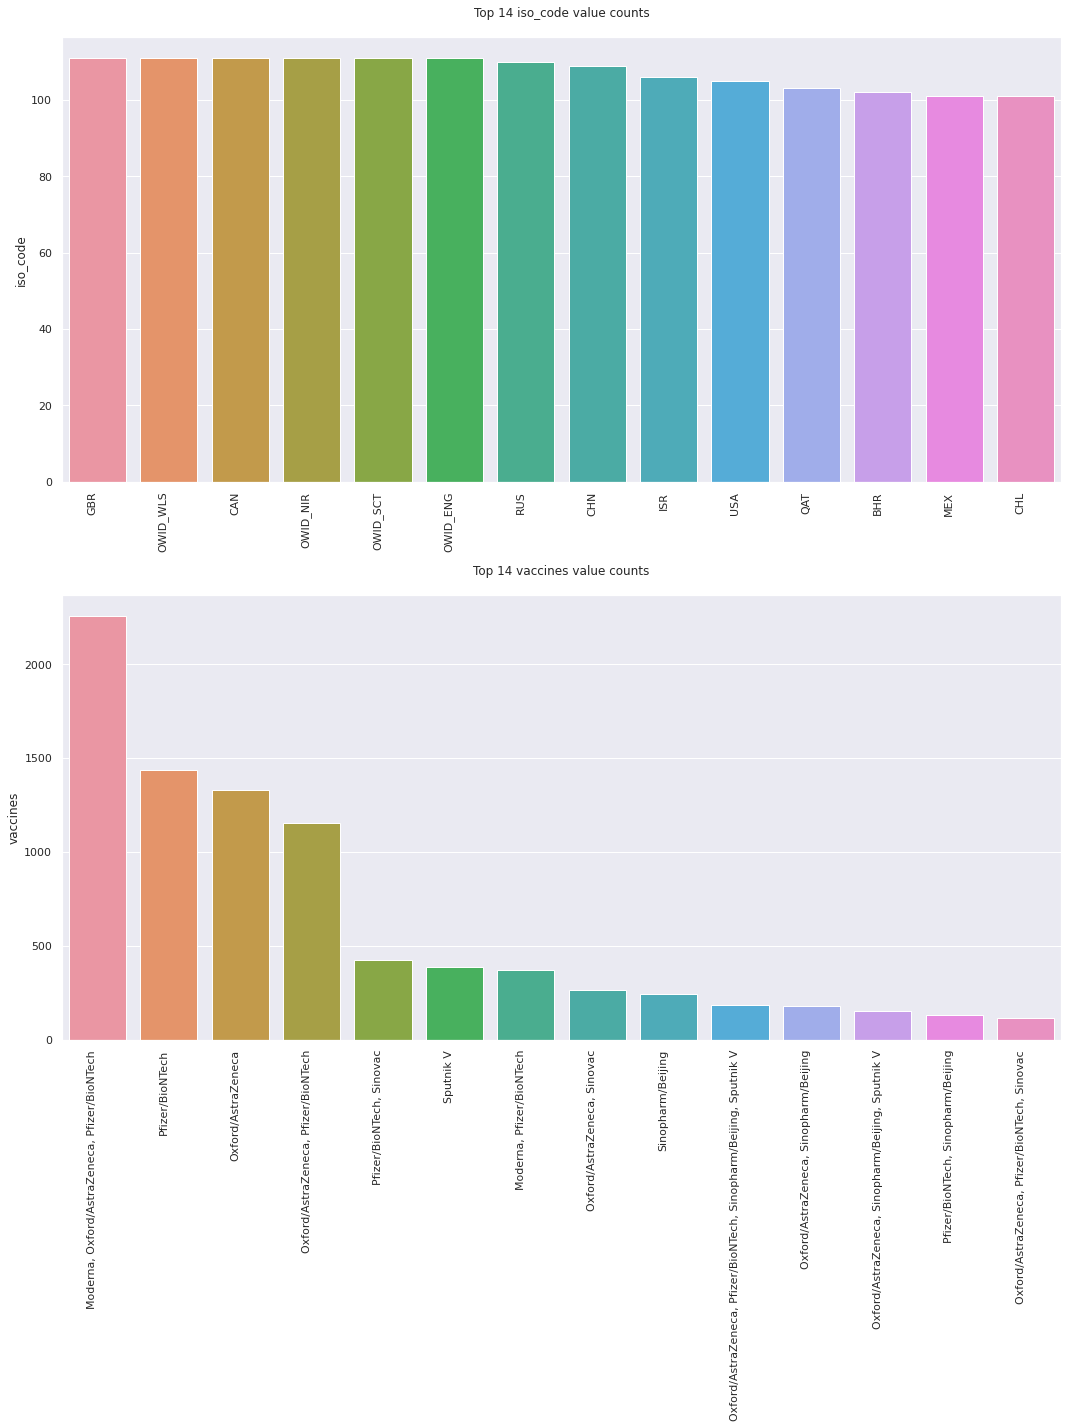

In [197]:
# Print top 10 Value counts for two important categorical columns
def viz_iso_and_vaccine_val_counts(covid_orig_df, top=10):
    val_cnts = {}
    val_cnts['iso_code'] = covid_orig_df['iso_code'].value_counts().nlargest(top)
    val_cnts['vaccines'] = covid_orig_df['vaccines'].value_counts().nlargest(top)
    logger.info(f"Country ISO Value Counts:\n{val_cnts['iso_code']}\n")
    logger.info(f"Types of Vaccines Value Counts:\n{val_cnts['vaccines']}\n")
    # Plot them
    sns.set(font_scale=1.0)
    cols_to_visualize = ['iso_code', 'vaccines']
    fig, ax = plt.subplots(nrows=len(cols_to_visualize), ncols=1, figsize=(15, 20))
    for ind, cat_col in enumerate(cols_to_visualize):
        ax[ind].set_title(f"Top {top} {cat_col} value counts")
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(), rotation=90, ha="right")
        sns.barplot(x=val_cnts[cat_col].index,
                         y=val_cnts[cat_col], ax=ax[ind])    
    plt.tight_layout()
    plt.show()
viz_iso_and_vaccine_val_counts(covid_orig_df, top=14)

<AxesSubplot:>

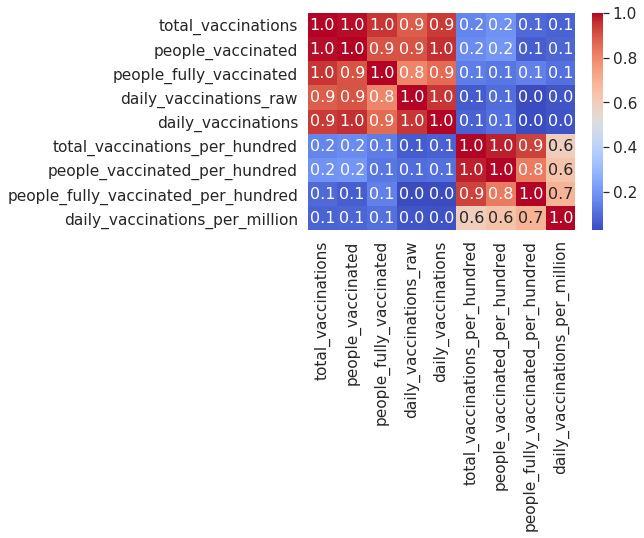

In [173]:
# Find Correlations between columns
numerical_cols = list(covid_orig_df.describe().columns)
sns.set(font_scale=1.4)
sns.heatmap(data=covid_orig_df[numerical_cols].corr(), 
            cmap='coolwarm', annot=True, fmt=".1f",annot_kws={'size':16})

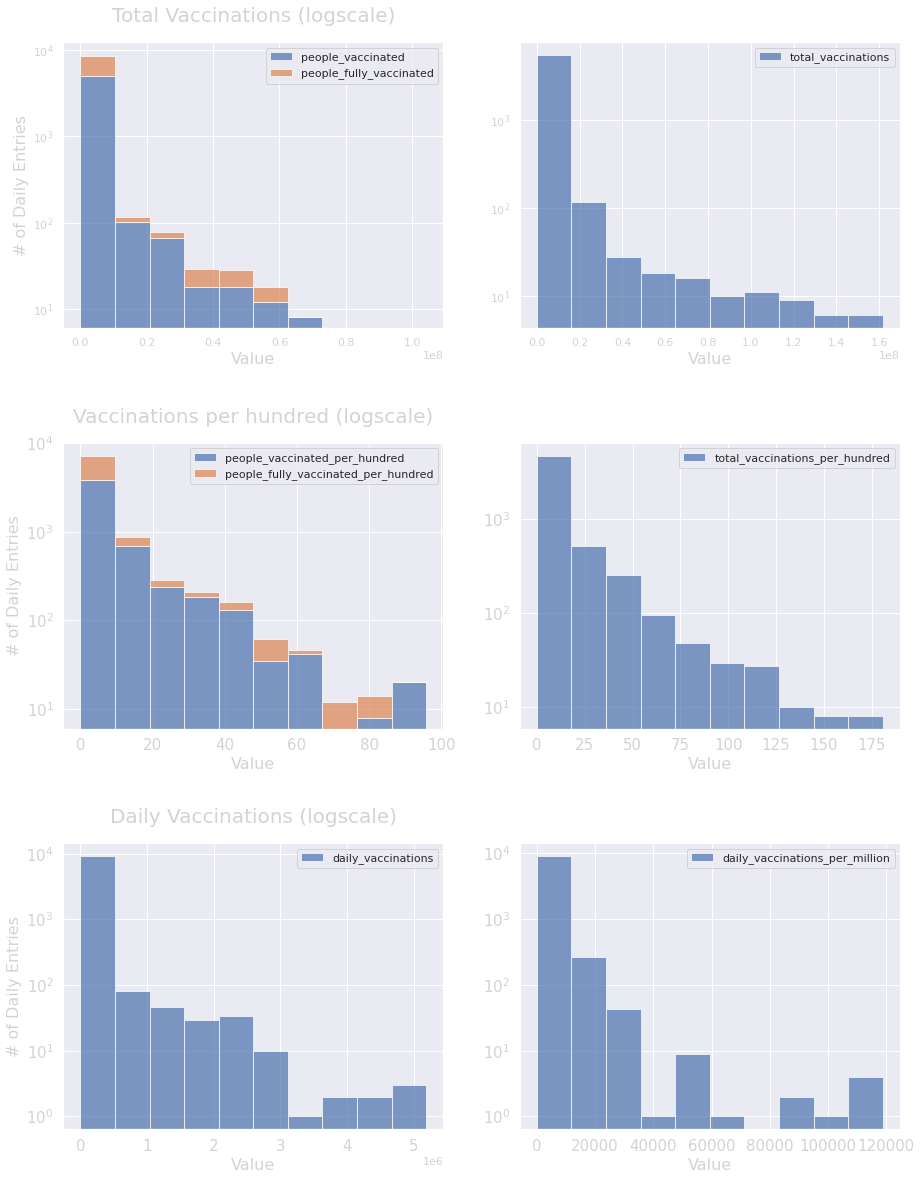

In [219]:
# Plot histograms with the values of important numerical columns
def plot_vaccine_columns(covid_orig_df):
    # Configure the grid of the plot
    fig, _ = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
    ax = []
    ax.append(plt.subplot2grid((3, 2), (0, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (0, 1), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (1, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (1, 1), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (2, 0), fig=fig))
    ax.append(plt.subplot2grid((3, 2), (2, 1), fig=fig))
    plt.subplots_adjust(hspace=0.4)

    # Plot using Pandas

    # First Row - First Column
    ax[0].tick_params(axis="both", colors=text_color)
    ax[0].set_title('Total Vaccinations (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['people_vaccinated', 'people_fully_vaccinated']]\
                .plot.hist(ax=ax[0], fontsize=11, alpha=0.7, logy=True, stacked=True)
    ax[0].set_xlabel('Value', fontsize=16, c=text_color)
    ax[0].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # First Row - Second Column
    ax[1].tick_params(axis="both", colors=text_color)
    covid_orig_df[['total_vaccinations']]\
                .plot.hist(ax=ax[1], fontsize=11, alpha=0.7, logy=True)
    ax[1].set_xlabel('Value', fontsize=16, c=text_color)
    ax[1].set_ylabel('')
    # Second Row - First Column
    ax[2].tick_params(axis="both", colors=text_color)
    ax[2].set_title('Vaccinations per hundred (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']]\
                .plot.hist(ax=ax[2], fontsize=15, alpha=0.7, logy=True, stacked=True)
    ax[2].set_xlabel('Value', fontsize=16, c=text_color)
    ax[2].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # Second Row - Second Column
    ax[3].tick_params(axis="both", colors=text_color)
    covid_orig_df[['total_vaccinations_per_hundred']]\
                .plot.hist(ax=ax[3], fontsize=15, alpha=0.7, logy=True)
    ax[3].set_xlabel('Value', fontsize=16, c=text_color)
    ax[3].set_ylabel('', fontsize=16, c=text_color)
    # Third Row - First Column
    ax[4].tick_params(axis="both", colors=text_color)
    ax[4].set_title('Daily Vaccinations (logscale)', fontsize=20, c=text_color)
    covid_orig_df[['daily_vaccinations']]\
                .plot.hist(ax=ax[4], fontsize=15, alpha=0.7, logy=True, stacked=True)
    ax[4].set_xlabel('Value', fontsize=16, c=text_color)
    ax[4].set_ylabel('# of Daily Entries', fontsize=16, c=text_color)
    # Third Row - Second Column
    ax[5].tick_params(axis="both", colors=text_color)
    covid_orig_df[['daily_vaccinations_per_million']]\
                .plot.hist(ax=ax[5], fontsize=15, alpha=0.7, logy=True)
    ax[5].set_xlabel('Value', fontsize=16, c=text_color)
    ax[5].set_ylabel('', fontsize=16, c=text_color)

# Call the plotting function
plot_vaccine_columns(covid_orig_df)

### Transform/Clean the dataset

#### Visualize null values

HeatMap Description
- -1: Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
- 0: No correlation represents that variables values present or absent do not have any effect on one another.
- 1: Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present


2021-04-08 22:29:48 JupyterMain  INFO     Missing Values:
iso_code                                  0
date                                      0
vaccines                                  0
people_vaccinated                      4409
people_fully_vaccinated                5968
total_vaccinations                     3804
people_vaccinated_per_hundred          4409
people_fully_vaccinated_per_hundred    5968
total_vaccinations_per_hundred         3804
daily_vaccinations                      183
daily_vaccinations_per_million          183
dtype: int64


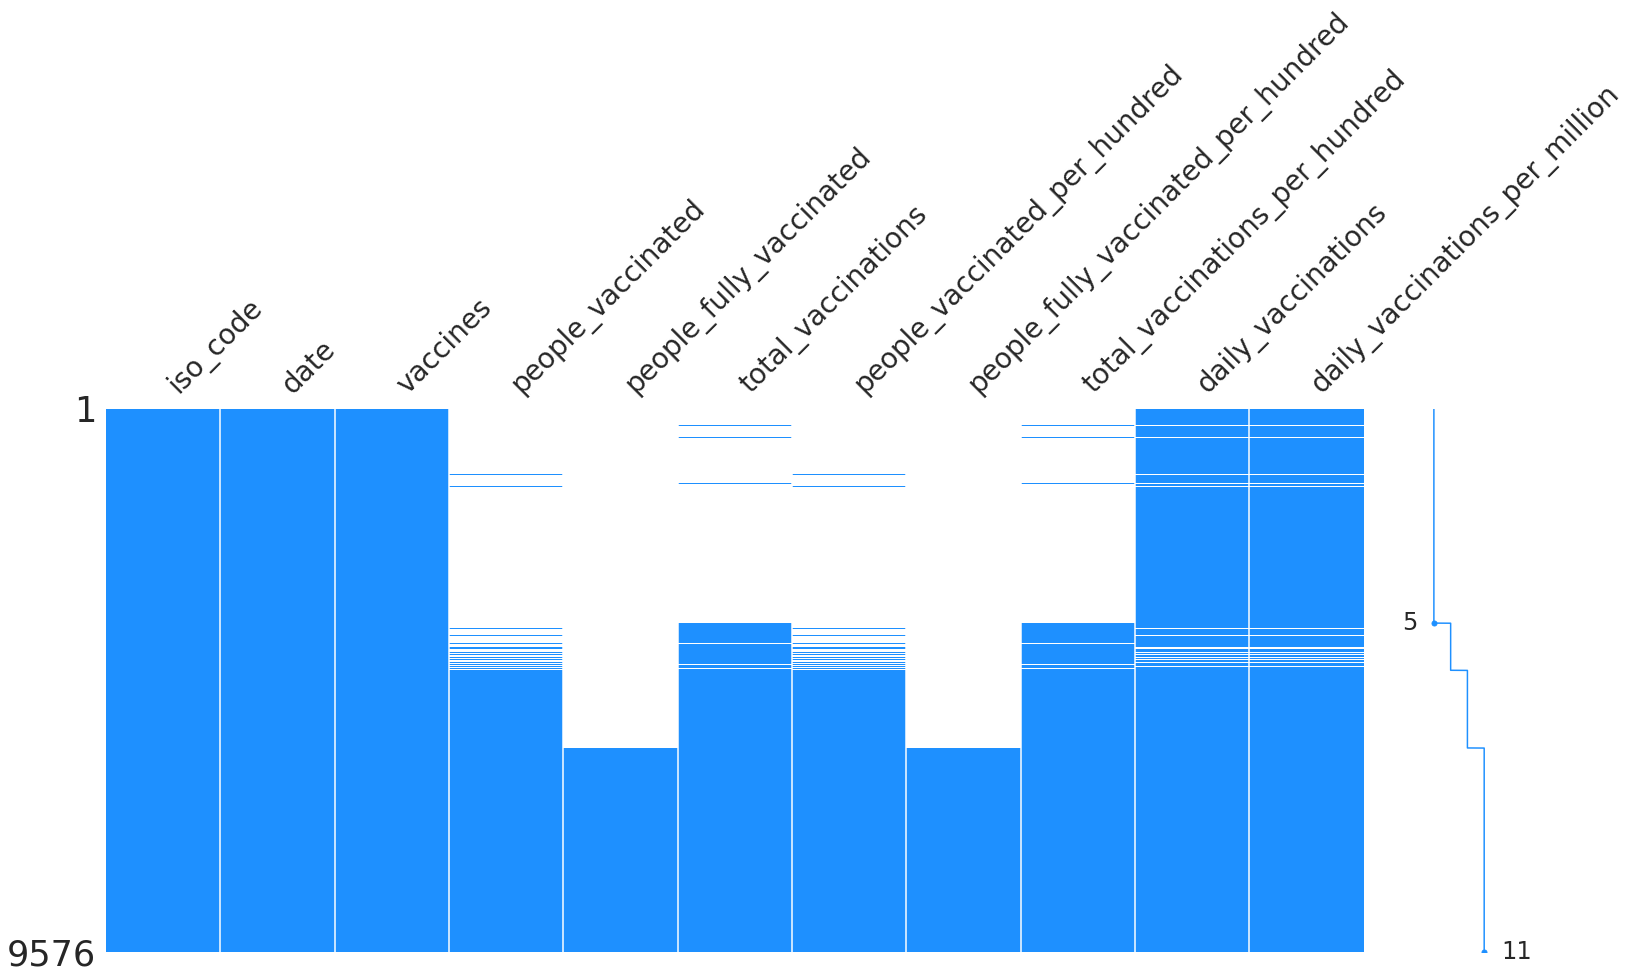

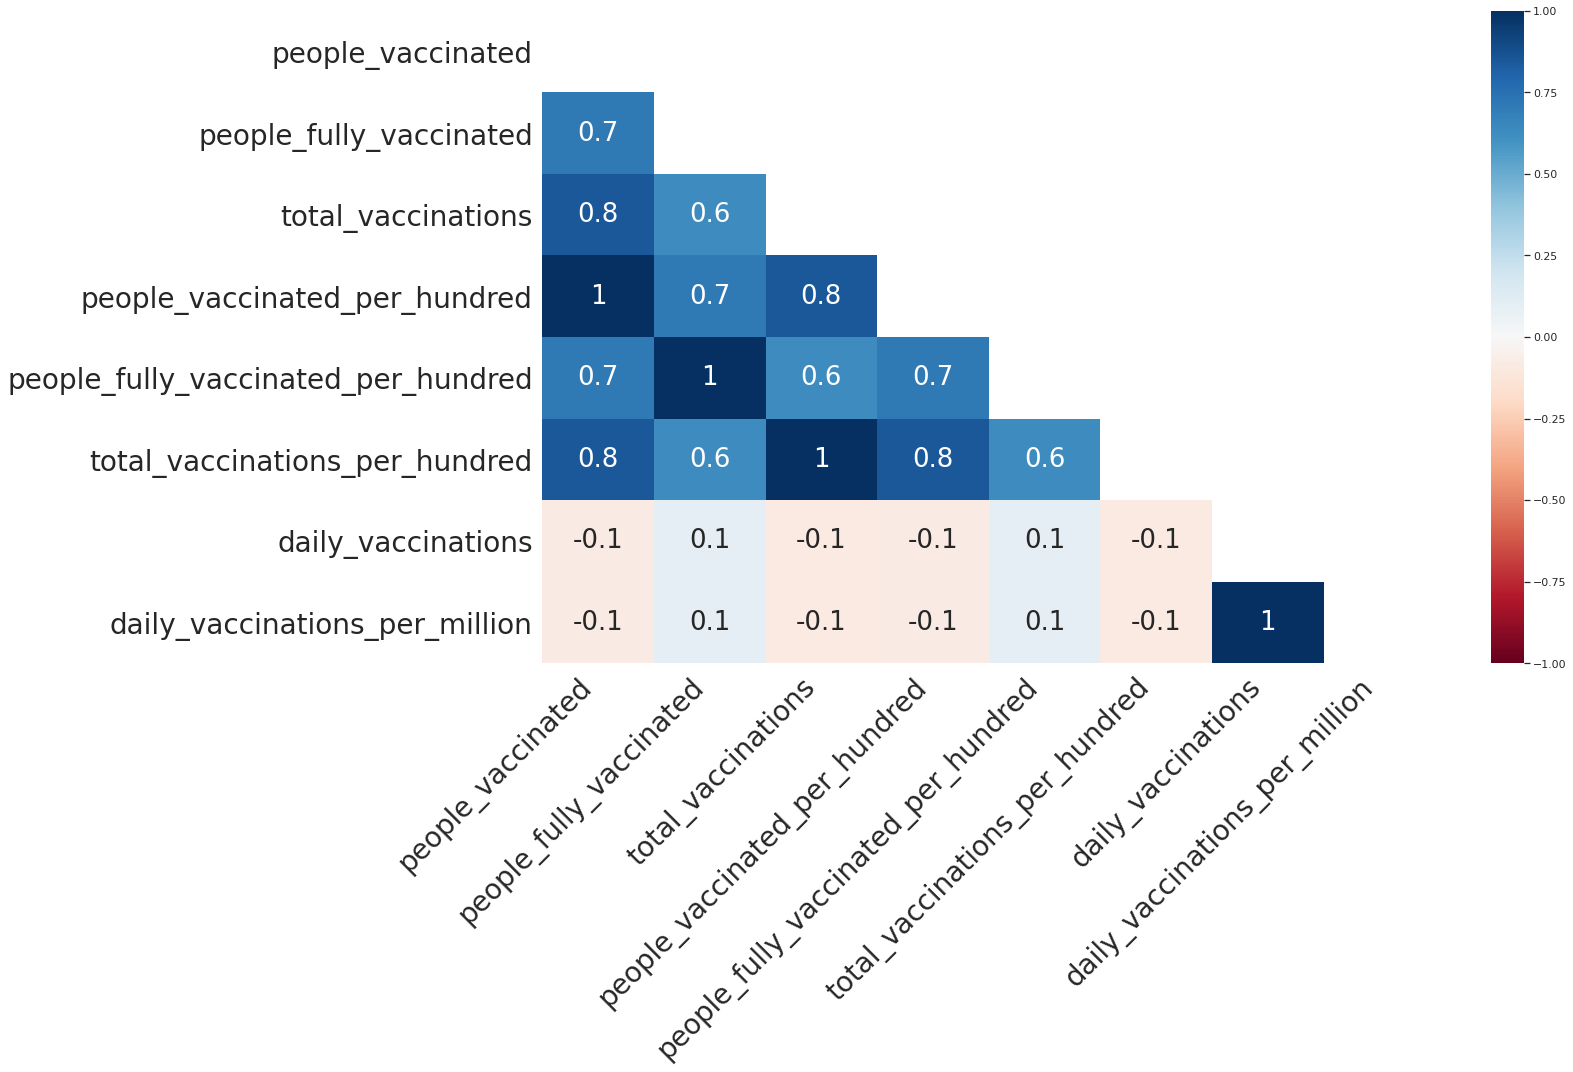

In [216]:
# Visualize Missing Values
def viz_missing_vals(covid_df):
    important_cols = ['iso_code', 'date', 'vaccines', 
                      'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations', 
                      'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
                      'total_vaccinations_per_hundred','daily_vaccinations', 
                      'daily_vaccinations_per_million']
    logger.info(f"Missing Values:\n{covid_orig_df[important_cols].isna().sum()}")
    covid_df = covid_orig_df[important_cols]
    # msno.bar(covid_df, fontsize=24, color="dodgerblue")
    # Visualize rows to find which columns are null
    msno.matrix(covid_df, fontsize=28, sort='ascending', color=(0.118, 0.565, 1))
    # Visualize heatmap to find correlations between columns when they have null values
    msno.heatmap(covid_df, cmap="RdBu", fontsize=28)
viz_missing_vals(covid_df)

We find that the columns with most missing values are:
- people_vaccinated 
- people_fully_vaccinated
- total_vaccinations
- people_vaccinated_per_hundred
- people_fully_vaccinated_per_hundred
- total_vaccinations_per_hundred

We also find that the missing values of daily_vaccinations and daily_vaccinations_per_million are not correlated with any other columns. It's of course obvious that columns with their per_hunder or per_million versions are always missing at the same time.
<br>
Let's print some of the rows with missing values to see exactly what's happening.

In [211]:
# Print some rows with NaNs
display(covid_df[covid_df['daily_vaccinations'].isna()].head(n=2))
display(covid_df[covid_df['total_vaccinations'].isna()].head(n=2))
display(covid_df[covid_df['people_vaccinated'].isna()].head(n=2))

,iso_code,date,vaccines,people_vaccinated,people_fully_vaccinated,total_vaccinations,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations,daily_vaccinations_per_million
0,AFG,2021-02-22,Oxford/AstraZeneca,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN
23,ALB,2021-01-10,"Pfizer/BioNTech, Sinovac",0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN


,iso_code,date,vaccines,people_vaccinated,people_fully_vaccinated,total_vaccinations,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations,daily_vaccinations_per_million
1,AFG,2021-02-23,Oxford/AstraZeneca,NaN,NaN,NaN,NaN,NaN,NaN,1367.0,35.0
2,AFG,2021-02-24,Oxford/AstraZeneca,NaN,NaN,NaN,NaN,NaN,NaN,1367.0,35.0


,iso_code,date,vaccines,people_vaccinated,people_fully_vaccinated,total_vaccinations,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations,daily_vaccinations_per_million
1,AFG,2021-02-23,Oxford/AstraZeneca,NaN,NaN,NaN,NaN,NaN,NaN,1367.0,35.0
2,AFG,2021-02-24,Oxford/AstraZeneca,NaN,NaN,NaN,NaN,NaN,NaN,1367.0,35.0


From the previous cell we got some ideas that for these cases:
1. when people_vaccinated and/or total_vaccinations are 0.0 and daily_vaccinations are null then everything else is null too
2. Even though we have daily vaccinations, we still have nans on the totals. Maybe, It's the first days of vaccinations for this country? Maybe we can put zeros on these cases


In [229]:
# Select  Greece
gr_covid_df = covid_df[covid_df['iso_code'] == 'GRC']
logger.info(f"Number of rows for Greece: {len(gr_covid_df.index)}")
# text_color = 'black'
# plot_vaccine_columns(gr_covid_df)

In [237]:
gr_covid_df['date'] =pd.to_datetime(gr_covid_df['date'])
gr_covid_df.sort_values(by='date').head()
# First of all we can find the rows that are the first for each 
# country with non-zero daily vaccines and impute 0.0 to the relevant columns
# If everything fails I can straight up recalculate all the computable columns 


<ipython-input-237-3bb4abff36c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_covid_df['date'] =pd.to_datetime(gr_covid_df['date'])


,iso_code,date,vaccines,people_vaccinated,people_fully_vaccinated,total_vaccinations,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations,daily_vaccinations_per_million
3366,GRC,2020-12-28,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",447.0,NaN,447.0,0.00,NaN,0.00,NaN,NaN
3367,GRC,2020-12-29,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",1077.0,NaN,1077.0,0.01,NaN,0.01,630.0,60.0
3368,GRC,2020-12-30,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",1722.0,NaN,1722.0,0.02,NaN,0.02,638.0,61.0
3369,GRC,2020-12-31,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",2339.0,NaN,2339.0,0.02,NaN,0.02,631.0,61.0
3370,GRC,2021-01-01,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",2603.0,NaN,2603.0,0.02,NaN,0.02,539.0,52.0


#### Feature Engineering: Drop, Impute, Transform, Merge Columns

In [ ]:
# Drop or Impute Columns with Nulls
covid_df_clean = covid_df.drop(covid_df[covid_df['total_vaccinations'].isna()].index)

In [ ]:
# OneHotEncode the 'vaccines' columns


### Normalize and standarize the dataset

In [175]:
# Pivot Table for each country
pd.pivot_table(covid_orig_df, index='iso_code', 
               values = ['people_vaccinated_per_hundred',
                         'people_fully_vaccinated_per_hundred'])

,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred
iso_code,,
AFG,NaN,0.053333
AGO,NaN,0.166000
AIA,NaN,20.420000
ALB,0.016000,0.031250
AND,1.600000,3.198889
...,...,...
USA,7.178684,13.018222
VEN,NaN,0.022500
VNM,NaN,0.029286


In [ ]:
# Normalize, standarize

### Try to find naively find bottlnecks manually by looking at different countries data

In [ ]:
# Further feature engineering to find bottlnecks
# Create columns that indicate the average daily values for the past 3, 7, 14 days
# Similarly to GNU/Linux's Load Average
# Target columns can be a boolean that indicates if today's value is far too low compared
# to previous datys
# Use these columns to guess bottlnecks
# Plotting a decision for these values tree may be useful

### First Stage of Clustering

In [ ]:
# Try different algorithms for this step
# Kmeans, DBSCAN, BIRCH, Mean Shift, OPTICS, Spectral Clustering, Gaussian Mixture Model

In [ ]:
# Evaluate the quality of the clusters
# Try to use exclude some columns to see how clustering changes
# Try Dimensionality Reduction to plot the results

### Use the clusters to see how the bottlnecks propage

In [ ]:
# Probably more feaure engineering needed
# Anomaly detection may be a good technique here
# Some Examples:
# https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

In [ ]:
# Theoritically the project can end here

### Data Enrichment


In [ ]:
# Try to enrich the dataset with more columns such GDP, region, %literacy, net migration
# Relecant Dataset: https://www.kaggle.com/fernandol/countries-of-the-world

### Recalculate clusters

In [ ]:
# Try to cluster again using the enriched dataset

### Predict again the bottlnecks

In [ ]:
# Use the new clusters to predict the bottlnecks

### Compare Results, Visualizations